# DDSC Project: Audio Sentiment Analysis

## Exploratory Data Analysis

In [210]:
import os
from os import walk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa


In [2]:
# parse the file names into a numpy matrix, each row represents one file.
RAW_DATA_PATH = '../data/raw'
dirs = []
for (dirpath, dirnames, _) in walk(RAW_DATA_PATH):
    for d in dirnames:
        if d.startswith("Actor"):
            dirs.append(dirpath+'/'+d)
    break
    
all_files = []
for actor in dirs:
    for(_,_,files) in walk(actor):
        all_files+=[i.split('.')[0].split('-') for i in files]
        break
all_files = [[int(i) - 1 for i in row] for row in all_files]

files = np.array(all_files)
print(files)

[[ 2  0  4 ...  1  0 15]
 [ 2  0  5 ...  1  1 15]
 [ 2  0  5 ...  0  1 15]
 ...
 [ 2  0  1 ...  0  0  7]
 [ 2  0  1 ...  1  0  7]
 [ 2  0  0 ...  1  1  7]]


In [3]:
def matrix_to_filename(matrix, RAW_DATA_PATH):
    filepaths = []
    for row in matrix:
        filename = ''
        for col in row:
            filename+=str(col+1).zfill(2)
            filename+='-'
        filename = filename[:-1]
        filename+='.wav'
        filepaths.append(RAW_DATA_PATH+'/Actor_'+str(row[6]+1).zfill(2)+'/'+filename)
        # print(filename)
    return filepaths
def plot_counts(files):
    print(f"Total number of files {files.shape[0]}")

    labels = [['full-AV', 'video-only', 'audio-only'],
             ['speech', 'song'],
             ['neutral' , 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust','surprised'],
             ['normal', 'strong'],
             ['Kids are talking by the door', 'Dogs are sitting by the door'],
             ['1st repetition', '2nd repetition'],
             ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
             ]
    titles = ['Modality', 'Vocal channel', 'Emotion', 'Emotional intensity' ,'Statement','Repetition' ,'Actor']
    
    fig, ax = plt.subplots(2, 4, figsize=(20, 10)) 
    inds = [(0,0), (0,1), (0,2), (0,3), (1,0), (1,1), (1,2), (1,3)]
    for i in range(7):
        unique, counts = np.unique(files[:, i], return_counts = True)
        unique = np.array(labels[i])[unique]
        ax[inds[i]].bar(unique, counts)
        ax[inds[i]].set_title(titles[i])
    ax[inds[-1]].axis('off')
    plt.suptitle("Count Plots")
    plt.tight_layout()
    plt.show()

Total number of files 1440


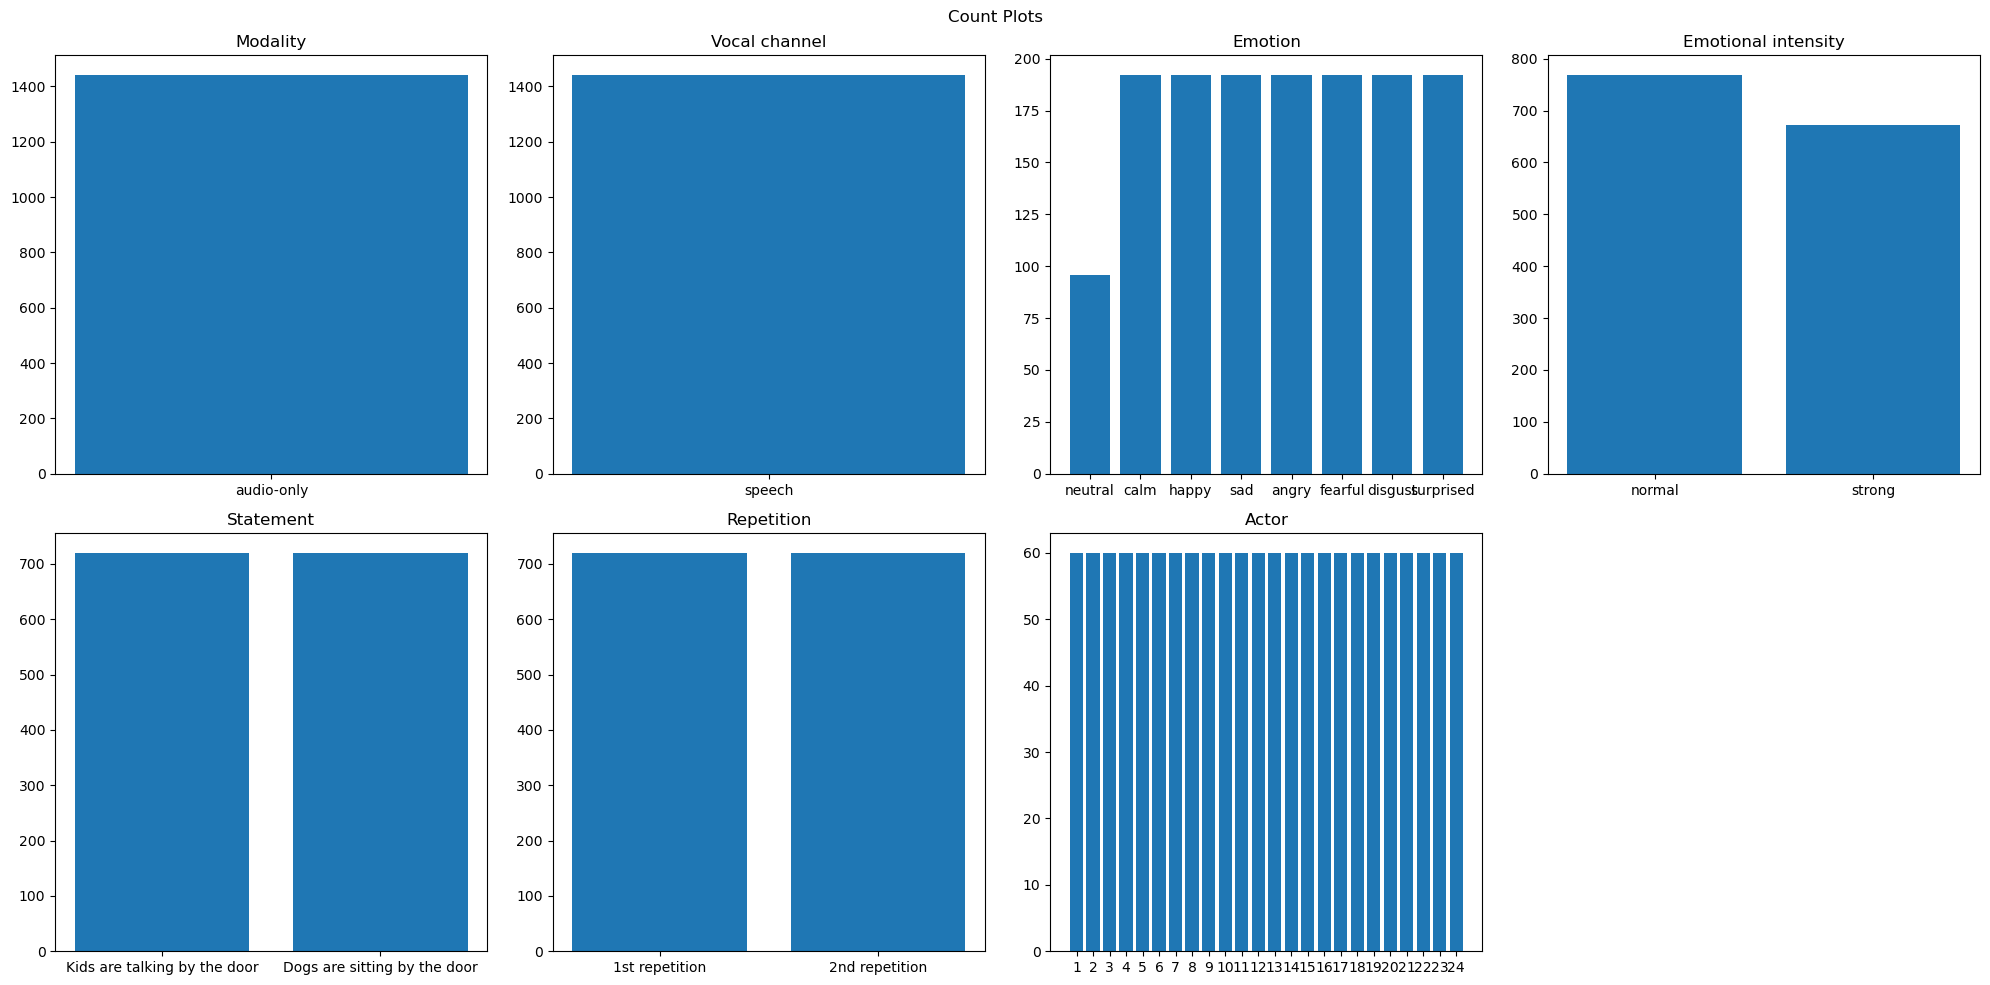

In [4]:
plot_counts(files)

Total number of files 96


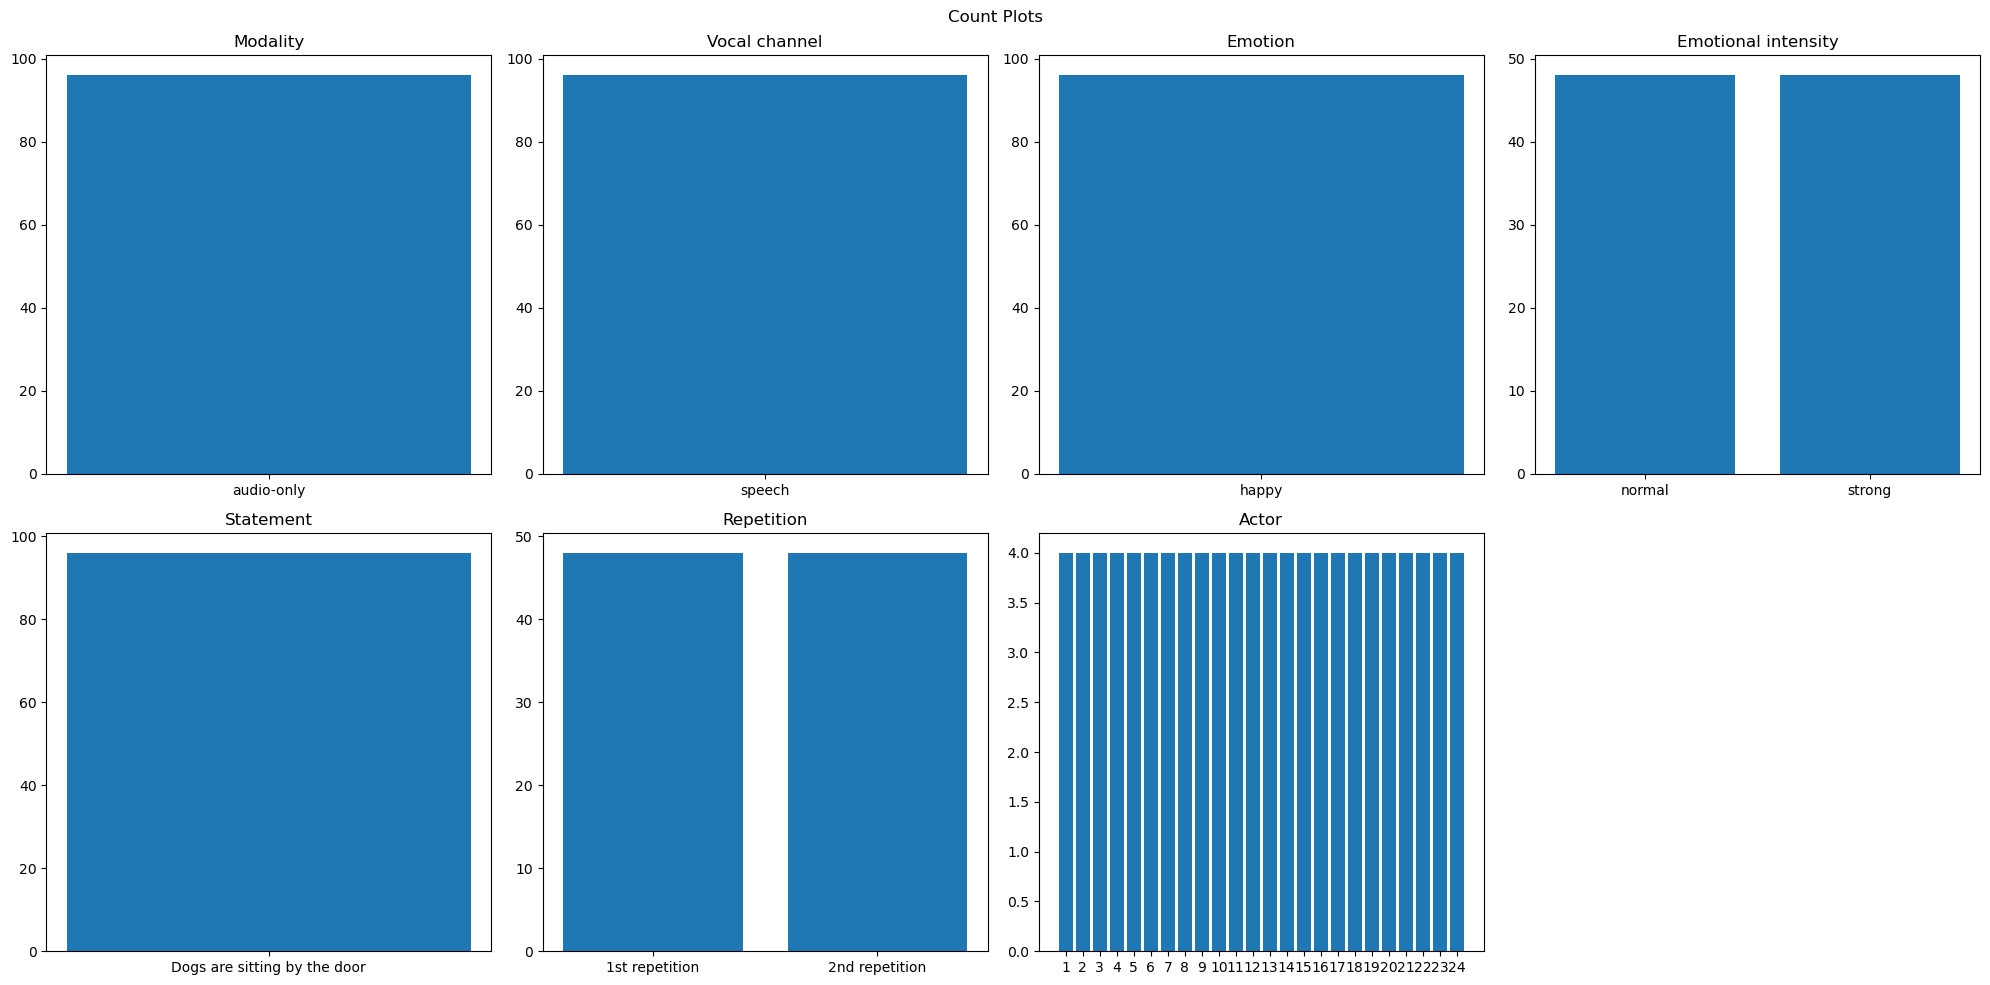

In [5]:
# plot only happy files with "dogs are sitting by the door"
mask = (files[:, 2] == 2 )
mask2 = (files[:, 4] == 1 )
extracted = files[mask&mask2]
plot_counts(extracted)

In [6]:
# average audio of all happy saying "dogs are sitting by the door"
#! pip install librosa
import librosa 
import librosa.display
from IPython.display import Audio, Image, display

filepaths = matrix_to_filename(extracted, RAW_DATA_PATH)
all_samples = []
for file in filepaths:
    samples, sample_rate = librosa.load(file, sr=None)
    all_samples.append(samples)

mn = min(len(row) for row in all_samples)
print(mn)

truncated_data = [row[:mn] for row in all_samples]
average_audio = np.mean(np.array(truncated_data), axis = 0)
Audio(data=average_audio, rate=48000)



150551


In [7]:
len(all_samples)

96

## Baseline Model

### Baseline Feature Extraction: MFCCs

**Mel-Frequency Cepstral Coefficients (MFCCs)** capture the timbral characteristics of speech, making them out primary choice for emotion classification analysis. Our baseline model relies on this feature to represent audio signals. 

The function below:

- Loads the audio file using its original sampling rate  
- Computes **40 MFCC coefficients** per frame  
- Ensures **fixed input size** by padding or trimming each MFCC matrix to `max_len = 400` frames  
- Returns a matrix of shape **(40, 400)** suitable as input to a 2D CNN  

This guarantees that every audio sample enters the model with consistent dimensionality.



In [197]:
def extract_mfcc(file_path, n_mfcc=40, max_len=400):
    """
    Extracts a CNN-ready MFCC matrix from an audio file.
    Output shape: (n_mfcc, max_len)
    """

    x, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc)

    # CNN expects every sample to have the same length
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    else:
        mfcc = mfcc[:, :max_len]

    return mfcc

### Preparing the Dataset: Converting Audio Files into MFCC Arrays

Once the MFCC extraction function is ready, the next step is to convert every audio file in the dataset into its MFCC representation. We loop through all file paths, extract MFCC features, and store them in a list.

After processing, we convert the list into a NumPy array so it can be fed directly into the model.  
We also parse the corresponding labels from the RAVDESS-style filename metadata:

- `emotion_labels`: the emotion category of each audio clip, ranging from 0-7 
- `actor_labels`: the speaker ID, ranging from 0-23  



In [198]:
all_mfcc = []
for path in all_filepaths:
    mfcc = extract_mfcc(path)
    all_mfcc.append(mfcc)

all_mfcc = np.array(all_mfcc)
all_labels = np.array(all_files)   
emotion_labels = all_labels[:, 2]  
actor_labels = all_labels[:, 6]

### Train–Test Split 

Here, we split the MFCC feature set into **training** and **testing** subsets using an 80/20 split.  


In [199]:
X = all_mfcc  
y = emotion_labels 
from sklearn.model_selection import train_test_split

# Train + Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

### Custom Dataset for MFCC Features

To prepare the MFCC features for training with PyTorch, we define a custom `MFCCDataset` class.  
This dataset wraps the MFCC matrices and their corresponding labels, handling both preprocessing and tensor conversion.

This provides a clean and reliable interface for PyTorch’s `DataLoader`, keeping the training pipeline organized and consistent.


In [200]:
import torch
from torch.utils.data import Dataset

class MFCCDataset(Dataset):

    def __init__(self, X, y=None):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # get sample (n_mfcc, time)
        x = self.X[idx]

        # add channel dimension -> (1, n_mfcc, time)
        x = np.expand_dims(x, axis=0)

        # to tensor
        x_tensor = torch.from_numpy(x)     

        y_tensor = torch.tensor(int(self.y[idx]), dtype=torch.long)
        return x_tensor, y_tensor

### DataLoader Setup

After creating the `MFCCDataset`, we wrap it with PyTorch’s `DataLoader` to efficiently feed data into the model during training and testing.


In [201]:
from torch.utils.data import DataLoader

# Instantiate the Datasets
train_dataset = MFCCDataset(X=X_train, y=y_train)
test_dataset = MFCCDataset(X=X_test, y=y_test)

# Instantiate DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)


test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

### Baseline CNN Model

To establish a starting point for performance, we implemented a simple convolutional neural network designed to classify emotions directly from MFCC features. 

This simple baseline model later gives us a clear comparison point to evaluate how much improvement comes from data augmentation and training refinements.


In [202]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNEmotionClassifier(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # (16, 40, 400)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)        # (16, 20, 200)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # (32, 20, 200)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)        # (32, 10, 100)
        )

        # flatten size = 32 * 10 * 100 = 32000
        self.fc = nn.Sequential(
            nn.Linear(32 * 10 * 100, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
 
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)

        x = x.view(x.size(0), -1)

        output = self.fc(x)
        return output

In [203]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNEmotionClassifier(num_classes=8).to(device)
loss_fn = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [204]:
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        outputs = model(X)

        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy


In [205]:
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            outputs = model(X)
            loss = loss_fn(outputs, y)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)

            correct += (predicted == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy

In [207]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 20

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, loss_fn, optimizer, device
    )
    test_loss, test_acc = evaluate(
        model, test_loader, loss_fn, device
    )

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | "
          f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")

Epoch 1/20: Train Loss=1.9416, Train Acc=0.2266 | Test Loss=1.8823, Test Acc=0.2847
Epoch 2/20: Train Loss=1.6930, Train Acc=0.3516 | Test Loss=1.7466, Test Acc=0.3542
Epoch 3/20: Train Loss=1.4227, Train Acc=0.4566 | Test Loss=1.6530, Test Acc=0.4028
Epoch 4/20: Train Loss=1.1954, Train Acc=0.5486 | Test Loss=1.5943, Test Acc=0.4062
Epoch 5/20: Train Loss=0.9320, Train Acc=0.6701 | Test Loss=1.5700, Test Acc=0.3819
Epoch 6/20: Train Loss=0.7142, Train Acc=0.7491 | Test Loss=1.6571, Test Acc=0.4167
Epoch 7/20: Train Loss=0.5106, Train Acc=0.8316 | Test Loss=1.6151, Test Acc=0.4340
Epoch 8/20: Train Loss=0.3761, Train Acc=0.8672 | Test Loss=1.5945, Test Acc=0.4931
Epoch 9/20: Train Loss=0.2628, Train Acc=0.9141 | Test Loss=1.7137, Test Acc=0.5104
Epoch 10/20: Train Loss=0.2260, Train Acc=0.9175 | Test Loss=1.7011, Test Acc=0.4688
Epoch 11/20: Train Loss=0.1986, Train Acc=0.9288 | Test Loss=1.7052, Test Acc=0.5069
Epoch 12/20: Train Loss=0.1793, Train Acc=0.9444 | Test Loss=1.9863, Test 

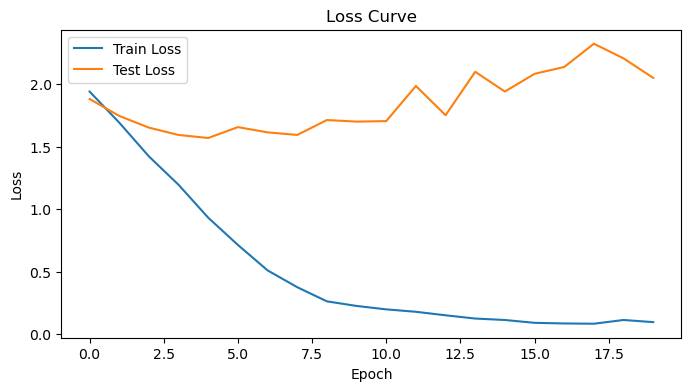

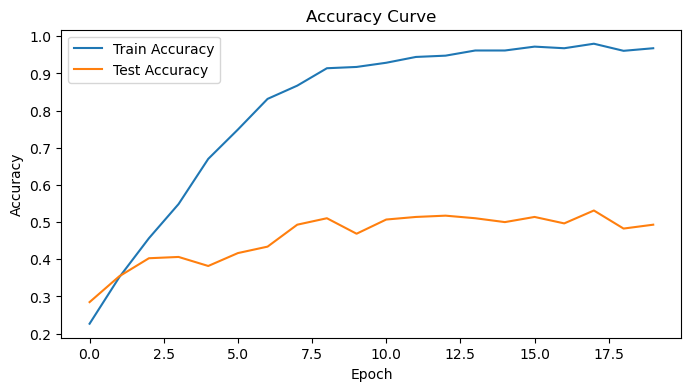

In [208]:
import matplotlib.pyplot as plt

# Loss plot
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# Accuracy plot
plt.figure(figsize=(8,4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()

### Baseline Model Performance 

The baseline CNN demonstrated steady improvement on the training set, reaching over **97% accuracy** by the final epoch. However, test accuracy remained much lower, plateauing around **50–53%** despite continued gains in training accuracy.

This clearly indicates **overfitting**:  
- The model quickly memorizes the training MFCC patterns.  
- It struggles to generalize to unseen speech samples.  
- Test loss also increases in the later epochs, reinforcing this behavior.

Overall, the baseline model provides a useful starting point, but its limited generalization shows the need for stronger regularization and data diversity. This motivates the enhancements introduced later in the project, including data augmentation, more feature extraction, and more robust training strategies.


### Data Augmentation 

To improve model generalization and reduce overfitting, we implemented several audio augmentation techniques. These methods artificially expand the dataset by creating realistic variations of each audio clip, helping the model learn more robust and invariant features.

**1. Additive Noise**  
Adds low-level random Gaussian noise to the waveform.  
This simulates real-world recording environments and prevents the model from over-relying on overly clean MFCC patterns.

**2. Time Stretching**  
Randomly speeds up or slows down the speech signal.  
This preserves pitch while altering speaking rate, teaching the model to recognize emotions regardless of tempo.

**3. Temporal Shifting**  
Shifts the waveform left or right by a random amount.  
This reduces sensitivity to the exact timing of speech onset and encourages temporal invariance.

**4. Pitch Shifting**  
Alters the pitch of the audio without affecting duration.  
Since human emotional tone varies naturally in pitch, this augmentation improves robustness across different speakers.

Overall, these augmentations create a richer and more diverse training dataset, making the model more capable of handling real-world variability in speech.


In [228]:
def augment_noise(x):
    noise_amp = 0.035 * np.random.uniform() * np.max(x)
    return x + noise_amp * np.random.normal(size=len(x))

def augment_stretch(x, rate=0.8):
    try:
        return librosa.effects.time_stretch(x, rate)
    except:
        return x  

def augment_shift(x):
    shift = np.random.randint(-5, 5) * 1000
    return np.roll(x, shift)

def augment_pitch(x, sr, pitch_factor=0.7):
    try:
        return librosa.effects.pitch_shift(x, sr, pitch_factor)
    except:
        return x


### Advanced Feature Extraction

To improve the model’s ability to interpret emotional content from speech, a richer set of audio features was extracted beyond the baseline MFCCs. The two functions below, `extract_features` and `extract_features_from_waveform`, compute multiple complementary features and wrap them into a matrix.

#### **Included Features**
| Feature | Description |
|--------|-------------|
| **MFCC** | Captures the spectral envelope of speech | 
| **Spectral Centroid** | Measures brightness of sound | 
| **Root Mean Square** | Computes short-time signal energy | 
| **Zero-Crossing Rate** | Measures frequency of sign changes |

Each feature is padded or trimmed to a fixed length of 400, then vertically stacked into a single 2D matrix.



In [262]:
def extract_features(file_path, n_mfcc=40, max_len=400):
    """
    Extract MFCC, Spectral Centroid, RMS, ZCR
    Output shape (43, 400): 40 from MFCC, 1 from Spectral Centroid, RMS and ZCR each
    """

    x, sr = librosa.load(file_path, sr=None)

    # MFCC 
    mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc)

    # Spectral Centroid 
    centroid = librosa.feature.spectral_centroid(y=x, sr=sr)

    # RMS 
    rms = librosa.feature.rms(y=x)

    # ZCR 
    zcr = librosa.feature.zero_crossing_rate(x)

    # reshape each feature to (num_features, 400)
    def reshape(feature, max_len):
        if feature.shape[1] < max_len:
            pad_width = max_len - feature.shape[1]
            feature = np.pad(feature, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            feature = feature[:, :max_len]
        return feature

    mfcc = reshape(mfcc, max_len)
    centroid = reshape(centroid, max_len)
    rms = reshape(rms, max_len)
    zcr = reshape(zcr, max_len)

    # stack vertically
    features = np.vstack([mfcc, centroid, rms, zcr])

    return features  

def extract_features_from_waveform(x, sr, n_mfcc=40, max_len=400):
    """
    Same as extract_features, but input is already loaded waveform x.
    """
    # MFCC
    mfcc = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=n_mfcc)

    # Spectral Centroid
    centroid = librosa.feature.spectral_centroid(y=x, sr=sr)

    # RMS
    rms = librosa.feature.rms(y=x)

    # ZCR
    zcr = librosa.feature.zero_crossing_rate(x)

    # reshape helper
    def reshape(feature, max_len):
        if feature.shape[1] < max_len:
            pad_width = max_len - feature.shape[1]
            feature = np.pad(feature, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            feature = feature[:, :max_len]
        return feature

    mfcc = reshape(mfcc, max_len)
    centroid = reshape(centroid, max_len)
    rms = reshape(rms, max_len)
    zcr = reshape(zcr, max_len)

    features = np.vstack([mfcc, centroid, rms, zcr])
    return features


### Data Augmentation Pipeline

The RAVDESS dataset is relatively small, and emotional speech varies widely in tone, loudness, and timing. Augmenting the audio helps the model learn emotion-invariant patterns and become more robust to real-world variations. The function `build_augmented_dataset` generates multiple transformed versions of each audio file, extracts extended acoustic features, and expands the training set by **5×**.



In [263]:
def build_augmented_dataset(filepaths, labels, n_mfcc=40, max_len=400):
    X_all = []
    y_all = []

    for path, label in zip(filepaths, labels):
        # Original
        x, sr = librosa.load(path, sr=None)
        X_all.append(extract_features_from_waveform(x, sr, n_mfcc, max_len))
        y_all.append(label)

        # Noise
        x_noise = augment_noise(x)
        X_all.append(extract_features_from_waveform(x_noise, sr, n_mfcc, max_len))
        y_all.append(label)

        # Shift
        x_shift = augment_shift(x)
        X_all.append(extract_features_from_waveform(x_shift, sr, n_mfcc, max_len))
        y_all.append(label)

        # Stretch
        x_stretch = augment_stretch(x)
        X_all.append(extract_features_from_waveform(x_stretch, sr, n_mfcc, max_len))
        y_all.append(label)

        # Pitch Shift
        x_pitch = augment_pitch(x, sr)
        X_all.append(extract_features_from_waveform(x_pitch, sr, n_mfcc, max_len))
        y_all.append(label)

    return np.array(X_all), np.array(y_all)


In [264]:
all_labels = np.array(all_files)   
emotion_labels = all_labels[:, 2]  
actor_labels = all_labels[:, 6]
X, y = build_augmented_dataset(all_filepaths, emotion_labels)

### Train–Validation–Test Split

To properly evaluate the advanced model and avoid overfitting, the dataset was divided into three parts:  
**training (80%)**, **validation (10%)**, and **testing (10%)**. The validation set is for tuning hyperparameters and monitoring generalization during training, while the test set is for the final evaluation.

Stratified sampling was used to preserve the original class distribution across all three subsets, ensuring a fair and balanced evaluation.


In [265]:
from sklearn.model_selection import train_test_split

# Train + Temp split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Val + Test split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)



### Updated Dataset Class 

The `AudioDataset` class builds on the baseline `MFCCDataset` above, but is updated to support the richer feature set and data augmentation pipeline used in the advanced model.

The updated `AudioDataset` class now handles 43-channel feature matrices (40 MFCC + spectral centroid + RMS + ZCR).


In [268]:
class AudioDataset(Dataset):
    """
    Dataset for augmented audio features.
    """

    def __init__(self, X, y=None, transform=None):
        self.X = X.astype(np.float32)
        self.y = None if y is None else y.astype(np.int64)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]

        if self.transform is not None:
            x = self.transform(x)

        # Add CNN channel: (1, 43, 400)
        x = np.expand_dims(x, axis=0)
        x_tensor = torch.from_numpy(x)

        if self.y is not None:
            y_tensor = torch.tensor(int(self.y[idx]), dtype=torch.long)
            return x_tensor, y_tensor
        else:
            return x_tensor


### Updated DataLoader

With the updated feature extraction pipeline and the introduction of a validation set, the DataLoader is also updated. It is now compatible with the updated `AudioDataset`

Moreover, instead of only train/test, the advanced model includes a dedicated validation set for tuning hyperparameters and monitoring overfitting.


In [269]:
from torch.utils.data import DataLoader

# Instantiate the three Datasets
train_dataset = AudioDataset(X=X_train, y=y_train)
val_dataset = AudioDataset(X=X_val, y=y_val)
test_dataset = AudioDataset(X=X_test, y=y_test)

# Instantiate DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

### Advanced CNN Model with Data Augmentation

Compared with the baseline model, this model is trained on **augmented features** including noise addition, time stretching, shifting, and pitch modification, which helps the model generalize better and achieve higher validation and test accuracy.


In [270]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNEmotionClassifier(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),   # (1, 43, 400) -> (16, 43, 400)
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                            # (16, 21, 200)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # (32, 21, 200)
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                            # (32, 10, 100)
        )

        # flatten = 32 * 10 * 100 = 32000
        self.fc = nn.Sequential(
            nn.Linear(32000, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [271]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNEmotionClassifier(num_classes=8).to(device)
loss_fn = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


### Early Stopping 

To prevent overfitting and reduce unnecessary training, we introduced an **Early Stopping** mechanism. The key idea is to monitor accuracy and stop training if it stops improving for a specified number of epochs `patience`.

The class keeps track of the best observed score and incremented the counter each epoch if the metric fails to improve. Training halts when the counter exceeds the patience threshold. This ensures that the model restores weights at the epoch with the best validation performance and avoids overfitting to the training data.


In [277]:
class EarlyStopping:
    def __init__(self, patience=10, mode='max'):  # 'max' for accuracy, 'min' for loss
        self.patience = patience
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.mode = mode 

    def __call__(self, value):
        score = value

        if self.best_score is None:
            self.best_score = score
        elif (self.mode == 'max' and score <= self.best_score) or \
             (self.mode == 'min' and score >= self.best_score):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


### Learning Rate Scheduler: ReduceLROnPlateau

To improve convergence and stabilize training, we use a **ReduceLROnPlateau** scheduler, which adjusts the learning rate dynamically.

The scheduler monitors the validation accuracy. If the best validation accuracy hasn't improved for 3 consecutive epochs, it multiplies the current learning rate by 0.5. This lets the optimizer take smaller steps to refine the model, helping it converge more smoothly thus improving overall model performance.


In [273]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',          
    patience=3,
    factor=0.5,
    min_lr=1e-5
)


### Training and Evaluation 
We define two core functions for training and evaluating our CNN model.

During the training process, we keep track of the accuracy and loss for both training and validation sets. With Learning Rate Scheduler, the learning rate will be automatically adjusted.

In [274]:
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        outputs = model(X)

        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy


In [275]:
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            outputs = model(X)
            loss = loss_fn(outputs, y)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)

            correct += (predicted == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy


In [276]:
num_epochs = 60

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

early_stopper = EarlyStopping(patience=10, mode='max')

best_val_acc = 0
best_model_state = None

for epoch in range(num_epochs):

    # Training 
    train_loss, train_acc = train_one_epoch(
        model, train_loader, loss_fn, optimizer, device
    )

    # Validation  
    val_loss, val_acc = evaluate(
        model, val_loader, loss_fn, device
    )

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Learning Rate Scheduler 
    scheduler.step(val_acc)

    # Track the best model 
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()

    # Early Stopping check 
    early_stopper(val_acc)
    if early_stopper.early_stop:
        print(f"\nEarly stopping at epoch {epoch+1}.")
        break

    print(
        f"Epoch {epoch+1}/{num_epochs}: "
        f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f} | "
        f"Val Loss={val_loss:.4f},   Val Acc={val_acc:.4f} | "
        f"LR={optimizer.param_groups[0]['lr']:.6f}"
    )

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nBest model restored (Val Acc = {best_val_acc:.4f})")


Epoch 1/60: Train Loss=27.0613, Train Acc=0.1420 | Val Loss=2.0713,   Val Acc=0.1333 | LR=0.001000
Epoch 2/60: Train Loss=2.0649, Train Acc=0.1372 | Val Loss=2.0305,   Val Acc=0.1556 | LR=0.001000
Epoch 3/60: Train Loss=2.0488, Train Acc=0.1437 | Val Loss=1.9971,   Val Acc=0.1681 | LR=0.001000
Epoch 4/60: Train Loss=2.0235, Train Acc=0.1677 | Val Loss=1.9653,   Val Acc=0.1944 | LR=0.001000
Epoch 5/60: Train Loss=2.0067, Train Acc=0.1675 | Val Loss=1.9696,   Val Acc=0.1847 | LR=0.001000
Epoch 6/60: Train Loss=1.9866, Train Acc=0.1738 | Val Loss=1.9387,   Val Acc=0.2014 | LR=0.001000
Epoch 7/60: Train Loss=1.9434, Train Acc=0.2000 | Val Loss=1.8440,   Val Acc=0.2708 | LR=0.001000
Epoch 8/60: Train Loss=1.8028, Train Acc=0.2583 | Val Loss=1.5984,   Val Acc=0.4056 | LR=0.001000
Epoch 9/60: Train Loss=1.6246, Train Acc=0.3382 | Val Loss=1.4262,   Val Acc=0.5014 | LR=0.001000
Epoch 10/60: Train Loss=1.4799, Train Acc=0.4092 | Val Loss=1.2695,   Val Acc=0.5819 | LR=0.001000
Epoch 11/60: Train

### Advanced CNN Training Results

The advanced CNN model with data augmentation, additional audio features (MFCC + Spectral Centroid + RMS + ZCR), and a validation set was trained for up to 60 epochs with early stopping and learning rate scheduling. 

Key observations from training:

- **Best Validation Accuracy**: 92.36%
- **Early stopping**: Triggered at epoch 50, since the validation accuracy was not improved for 10 consecutive epochs
- **Learning Rate Adjustment**: The learning rate was reduced automatically when validation accuracy plateaued, helping the model converge more smoothly.

This demonstrates that augmenting the dataset and including richer audio features significantly improved model generalization compared to the baseline CNN.


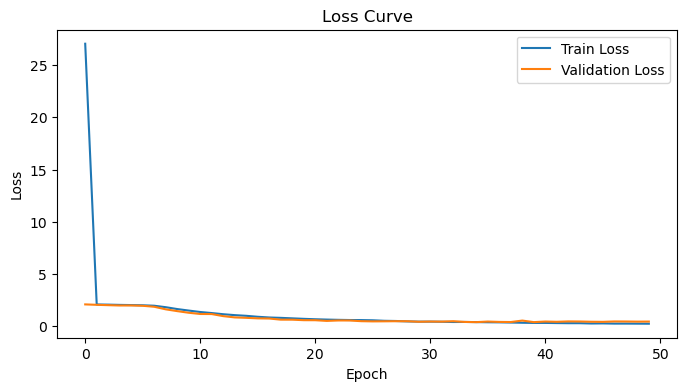

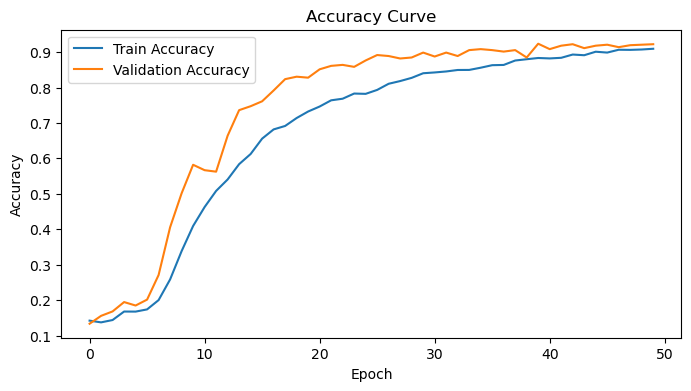

In [278]:
import matplotlib.pyplot as plt

# Loss plot
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# Accuracy plot
plt.figure(figsize=(8,4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()


In [279]:
test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
print(f"Test Loss={test_loss:.4f}, Test Accuracy={test_acc:.4f}")


Test Loss=0.3002, Test Accuracy=0.9333


In [280]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        outputs = model(X)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.numpy())





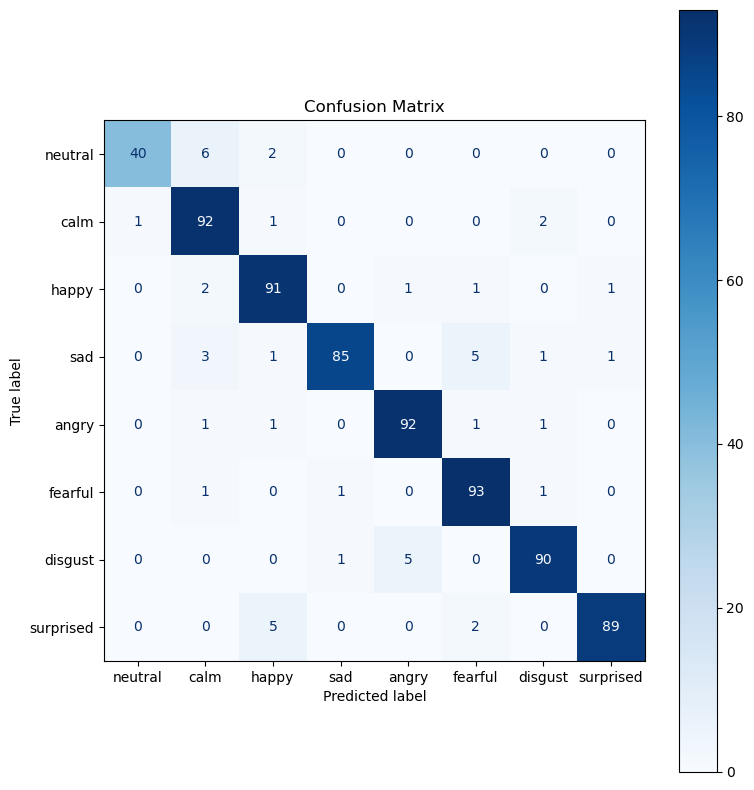

In [281]:
cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, 
    display_labels=
    [
    "neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"
    ]
)
disp.plot(ax=ax, cmap="Blues")

plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


### Testing Performance Summary

After training our CNN-based emotion classifier with data augmentation, early stopping, and adaptive learning rate scheduling, we evaluated the final restored model on the test set. Overall, the model demonstrates **strong generalization** across most emotion categories.

#### Accuracy 

| Emotion    | Correct | Total | Accuracy |
|-----------|---------|-------|----------|
| Fearful   | 93      | 96    | 96.88% |
| Calm      | 92      | 96    | 95.83% |
| Angry     | 92      | 96    | 95.83% |
| Happy     | 91      | 96    | 94.79% |
| Disgust   | 90      | 96    | 93.75% |
| Surprised | 89      | 96    | 92.71% |
| Sad       | 85      | 96    | 88.54% |
| Neutral   | 40      | 48    | 83.33% |
| **Overall**   | **662**     | **720**   | **91.94%** |




### Conclusion

- The model achieves 91.94% overall accuracy, demonstrates strong and reliable performance.
- Most emotions achieve above 90% accuracy including *Fearful*, *Calm*, *Angry*, *Happy* *Disgust* and *Surprised*, indicating that CNN learns and generalizes well in these emotions.
- *Neutral* and *Sad* show comparatively lower performance. This is likely because of the subtle acoustic differences between these low energy emotions. *Neutral* speech often lacks obvious patterns, making it acoustically ambiguous. *Sad* speechs sometimes were misclassified as *Neutral* or *Fearful* because these emotions are characterized by low energy acoustic features.
